# Lennard-Jones Potentials for modelling phase transitions in materials

Nested Sampling is the ideal tool for computing the partition function.

$$Z(\beta) = \int_\mathcal{X} e^{-\beta E(x)} \, \mathrm{d}x$$

where $\beta \in [0, \infty)$ is the inverse temperature parameter, $\mathcal{X}$ is the set of all configurations of the system, and $E : \mathcal{X} \to \mathbb{R}$ is the potential function, which in this case will be the Lennard-Jones potential,

$$E(x) = 4 \epsilon \sum_{i,j} \left( \left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6 \right).$$

In this equation, the $-\epsilon$ represents the energy of the ground state, and $\sigma$ is the equilibrium distance when the potential energy is zero.

The system is invariant to changes in sigma and the total size of the region. Therefore, we choose $\sigma$ as a ratio with the size of the box. We'll chose to sample states within a unit box, therefore, we are choosing how big the box is in units of $\sigma$. Choosing $\sigma=0.01$ is equivalent to choosing, means the volume is roughly 100 particles per side.

In [24]:


from jax import config

# config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import Model
from jaxns import Prior

tfpd = tfp.distributions


In [25]:

def pairwise_distances_squared(points):
    n = points.shape[0]
    pair_indices = jnp.triu_indices(n, 1)  # Upper triangular indices, excluding diagonal

    # Create function that calculates the distance between two points
    def dist_fn(ij):
        i, j = ij
        return jnp.sum(jnp.square(points[i] - points[j]))

    # Apply this function to each pair of indices
    pairwise_distances = vmap(dist_fn)(pair_indices)

    return pairwise_distances


def test_pairwise_distances_squared():
    # Example usage
    points = jnp.array([[1, 2], [3, 4], [5, 6], [7, 8]])
    assert jnp.all(pairwise_distances_squared(points) == jnp.asarray([8, 32, 72, 8, 32, 8]))

In [26]:


from jaxns.internals.log_semiring import LogSpace

num_particles = 4
sigma = jnp.asarray(0.439)
box_length = jnp.asarray(4.)


def log_likelihood(x):
    """
    V12-6 potential for LJ.
    """

    r2 = LogSpace(jnp.log(pairwise_distances_squared(x / sigma)))
    r6 = r2 * r2 * r2
    r12 = r6 * r6
    negE = r12 ** (-1) - r6 ** (-1)

    return negE.sum().log_abs_val


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.zeros((num_particles, 3)), high=box_length * jnp.ones((num_particles, 3))),
                    name='x')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(42), 1000)


INFO[2024-01-10 01:04:29,435]: Sanity check...
INFO[2024-01-10 01:04:29,461]: Sanity check passed


In [27]:
import jax
from jaxns import DefaultNestedSampler

# Create the nested sampler class. In this case without any tuning.
ns = DefaultNestedSampler(
    model=model,
    max_samples=1e6,
    s=model.U_ndims*1,
    k=0,
    c=model.U_ndims*20
)

ns_compiled = jax.jit(ns).lower(jax.random.PRNGKey(42)).compile()

termination_reason, state = ns_compiled(random.PRNGKey(42))

results = ns.to_results(
    termination_reason=termination_reason,
    state=state,
    trim=True
)


In [28]:
from jaxns import summary

# We can use the summary utility to display results
summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 211192171
samples: 40080
phantom samples: 0
likelihood evals / sample: 5269.3
phantom fraction (%): 0.0%
--------
logZ=285.44 +- 0.64
H=-100.15
ESS=683
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 0.92 +- 0.88 | 0.45 / 0.45 / 2.75 | 0.45 | 0.45
x[1]: 2.27 +- 0.65 | 1.15 / 2.58 / 2.58 | 2.58 | 2.58
x[2]: 0.4 +- 0.42 | 0.18 / 0.34 / 0.34 | 0.34 | 0.34
x[3]: 1.3 +- 0.7 | 0.92 / 0.92 / 2.75 | 0.92 | 0.92
x[4]: 2.7 +- 0.87 | 1.15 / 3.14 / 3.14 | 3.14 | 3.14
x[5]: 1.63 +- 0.67 | 0.18 / 1.91 / 1.91 | 1.91 | 1.91
x[6]: 1.45 +- 0.63 | 0.26 / 1.58 / 1.58 | 1.58 | 1.58
x[7]: 0.48 +- 0.14 | 0.45 / 0.45 / 0.74 | 0.45 | 0.45
x[8]: 1.5 +- 1.2 | 0.8 / 0.8 / 4.0 | 0.8 | 0.8
x[9]: 0.41 +- 0.21 | 0.08 / 0.45 / 0.45 | 0.45 | 0.45
x[10]: 2.54 +- 0.36 | 2.58 / 2.58 / 2.69 | 2.58 | 2.58
x[11]: 0.76 +- 0.91 | 0.34 / 0.34 / 2.75 | 0.34 | 0.34
--------


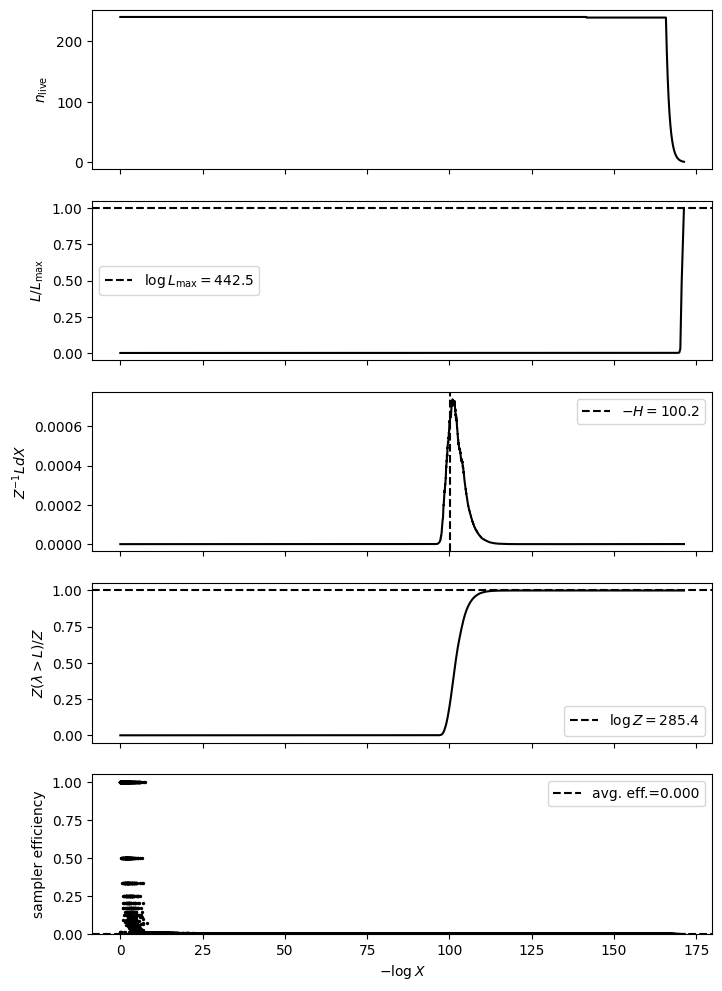

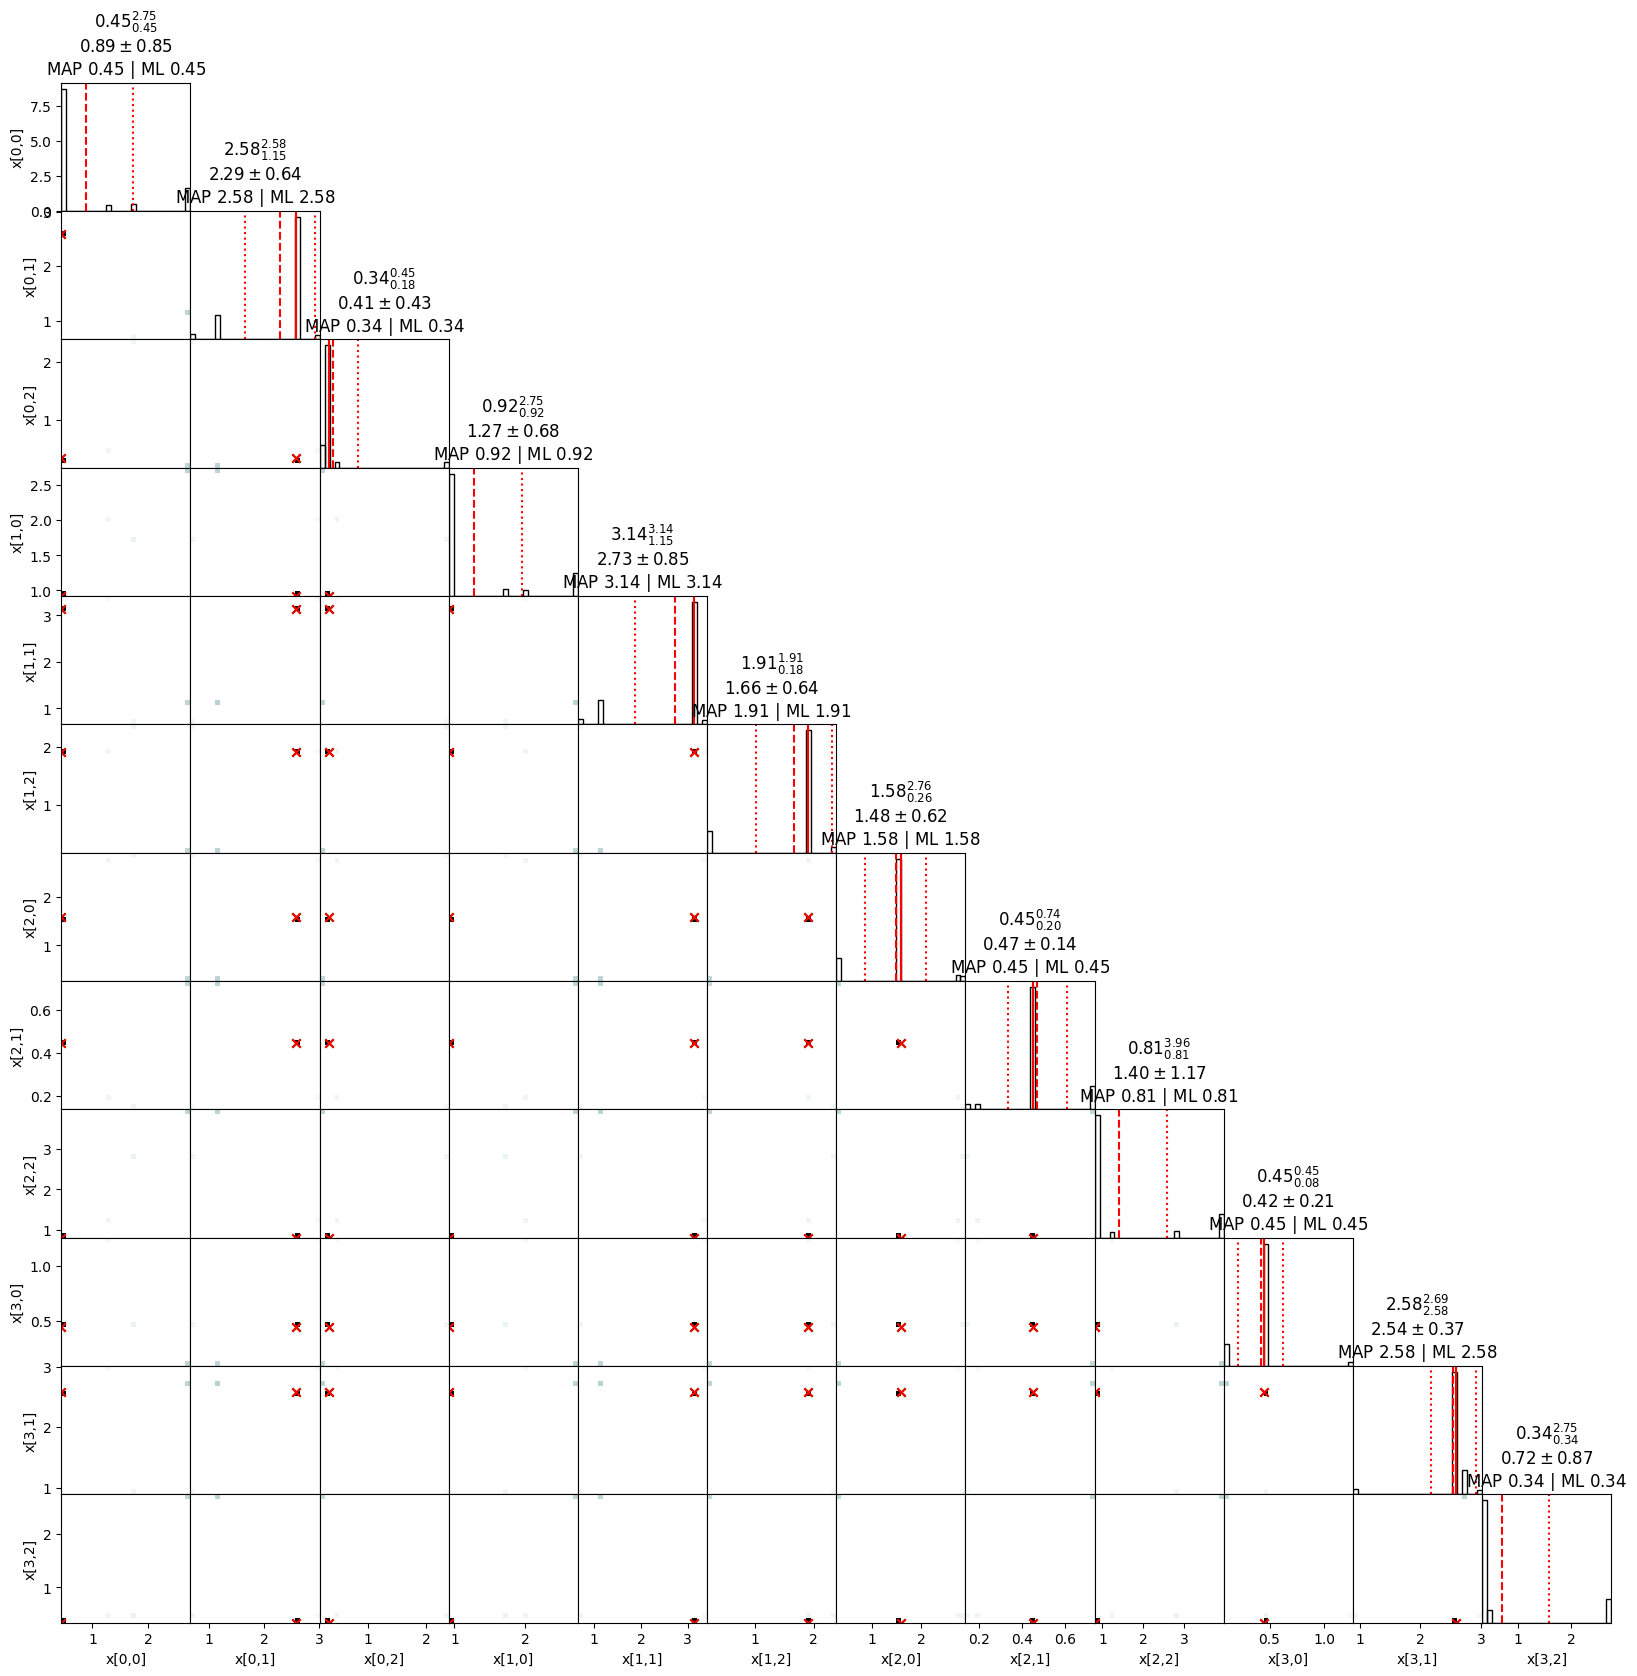

In [29]:
from jaxns import plot_diagnostics, plot_cornerplot

# We plot useful diagnostics and a distribution cornerplot
plot_diagnostics(results)
plot_cornerplot(results)


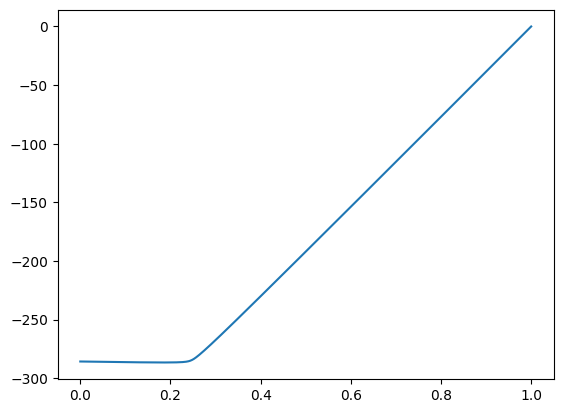

In [37]:
from jax import jit


@jit
def compute_partition(beta):
    # int dp(x) exp(beta E(x))
    dp = LogSpace(results.log_dp_mean)/LogSpace(results.log_L_samples)
    exp_beta_negE = LogSpace(beta * results.log_L_samples)
    return (dp * exp_beta_negE).sum().log_abs_val


x = []
y = []
for beta in jnp.linspace(0, 1, 2000):
    Z_beta = compute_partition(beta)
    x.append(beta)
    y.append(Z_beta)

import pylab as plt

plt.plot(x, y)
plt.show()